In [ ]:
def see_curves(trained_model):
    plt.figure(1, figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(trained_model.history['loss'], label=f'train')
    plt.plot(trained_model.history['val_loss'], label=f'valid')
    plt.xlabel('Nombre d\'epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(trained_model.history['accuracy'], label=f'train')
    plt.plot(trained_model.history['val_accuracy'], label=f'valid')
    plt.xlabel('Nombre d\'epochs')
    plt.ylabel('Accuracy')
    plt.legend()

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, Nadam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

%matplotlib inline

tf.keras.backend.clear_session()

filepath="gdrive/MyDrive/Colab Notebooks/Project lymphoma classification/weightsInception/V8/weightsInception.hdf5" #-improvement-{epoch:02d}-{val_loss:.3f}-{val_accuracy:.3f}
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

Mounted at /content/gdrive/


In [ ]:
model = Sequential()

inceptionV3 = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))
model.add(inceptionV3)
model.add(GlobalAveragePooling2D())


model.add(Dense(512,activation=('relu')))
model.add(Dropout(0.4))

model.add(Dense(256,activation=('relu')))
model.add(Dropout(0.4))

model.add(Dense(128,activation=('relu')))
model.add(Dropout(0.4))

model.add(Dense(64,activation=('relu')))
model.add(Dropout(0.4))


#3 outputs, activation function : softmax
model.add(Dense(3,activation=('softmax')))

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
# fix deep layers (fine-tuning only last 50)
for layer in model.layers[:-50]:
  layer.trainable = False

In [ ]:
datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range = 40,
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                shear_range = 0.2,
                zoom_range = 0.2,
                horizontal_flip=True)


datagenValit = ImageDataGenerator(rescale=1./255)

#batch size : 32
train_it = datagen.flow_from_directory('gdrive/MyDrive/Colab Notebooks/Project lymphoma classification/Data_DL_bigger/train/', class_mode='categorical', batch_size = 64, target_size=(224, 224))
val_it = datagenValit.flow_from_directory('gdrive/MyDrive/Colab Notebooks/Project lymphoma classification/Data_DL_bigger/validation/', class_mode='categorical', batch_size = 64, target_size=(224, 224))
test_it = datagenValit.flow_from_directory('gdrive/MyDrive/Colab Notebooks/Project lymphoma classification/Data_DL_bigger/validation/', class_mode='categorical', batch_size=64, shuffle=False,target_size=(224, 224))


batchX, batchy = train_it.next()

print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Found 10500 images belonging to 3 classes.
Found 840 images belonging to 3 classes.
Found 840 images belonging to 3 classes.
Batch shape=(64, 224, 224, 3), min=0.000, max=1.000


In [ ]:
#The Adam optimizer had the best accuracy of 99.2% in enhancing the CNN ability in classification and segmentation
model.compile(optimizer=Adam(lr=.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#weights_path="gdrive/MyDrive/Colab Notebooks/Project lymphoma classification/weightsInception/V5/weights-improvement-05-0.138-0.970.hdf5"

#model.load_weights(weights_path)
trained_model = model.fit_generator(train_it, epochs=100, validation_data=val_it, callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
165/165 [==============================] - 3103s 19s/step - loss: 1.2563 - accuracy: 0.3300 - val_loss: 1.0985 - val_accuracy: 0.3560

Epoch 00001: val_loss improved from inf to 1.09848, saving model to gdrive/MyDrive/Colab Notebooks/Project lymphoma classification/weightsInception/V8/weightsInception.hdf5
Epoch 2/100
165/165 [==============================] - 164s 991ms/step - loss: 1.1145 - accuracy: 0.3311 - val_loss: 1.0986 - val_accuracy: 0.3619

Epoch 00002: val_loss did not improve from 1.09848
Epoch 3/100
165/165 [==============================] - 162s 980ms/step - loss: 1.0970 - accuracy: 0.3465 - val_loss: 1.0828 - val_accuracy: 0.4393

Epoch 00003: val_loss improved from 1.09848 to 1.08279, saving model to gdrive/MyDrive/Colab Notebooks/Project lymphoma classification/weightsInception/V8/weightsInception.hdf5
Epoch 4/100
165/165 [==============================] - 163s 985ms/step - loss: 1.0705 - accuracy: 0.3585 - val_loss: 1.0376 - val_accuracy: 0.4298

Epoch 00

# **Confusion Matrix**

In [ ]:
best_weights_path="gdrive/MyDrive/Colab Notebooks/Project lymphoma classification/weightsInception/V5/weights-improvement-05-0.138-0.970.hdf5"
model.load_weights(best_weights_path)

val_steps = val_it.samples // 32

Y_pred = model.predict_generator(test_it, val_steps+1)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


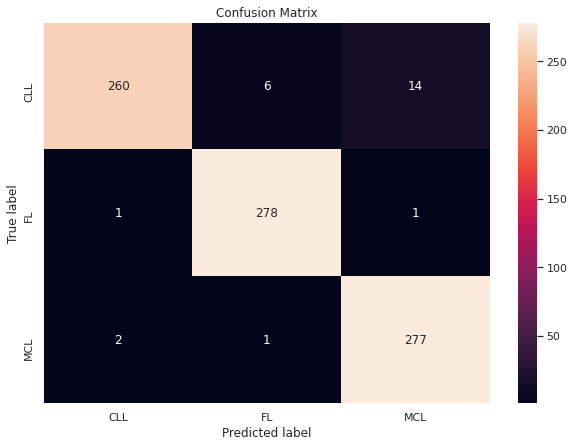

In [ ]:
# Confusion Matrix
df_cm = pd.DataFrame(confusion_matrix(test_it.classes, y_pred), index = ['CLL', 'FL', 'MCL'], columns = ['CLL', 'FL', 'MCL'])
plt.figure(figsize = (10,7))
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, fmt="d")

plt.title("Confusion Matrix") 
plt.xlabel("Predicted label") 
plt.ylabel("True label")
plt.show()

In [ ]:
# Classification Report
print('Classification Report')
print(classification_report(test_it.classes, y_pred, target_names=['CLL', 'FL', 'MCL']))

Classification Report
              precision    recall  f1-score   support

         CLL       0.99      0.93      0.96       280
          FL       0.98      0.99      0.98       280
         MCL       0.95      0.99      0.97       280

    accuracy                           0.97       840
   macro avg       0.97      0.97      0.97       840
weighted avg       0.97      0.97      0.97       840



# **Big DataSet**

In [2]:
#add 4 layers with dropout (1024,512,256,128,64) => dataSet 10500 => batch_size 64 => V8
# see_curves(trained_model)
print("resultat non convaincant")

resultat non convaincant


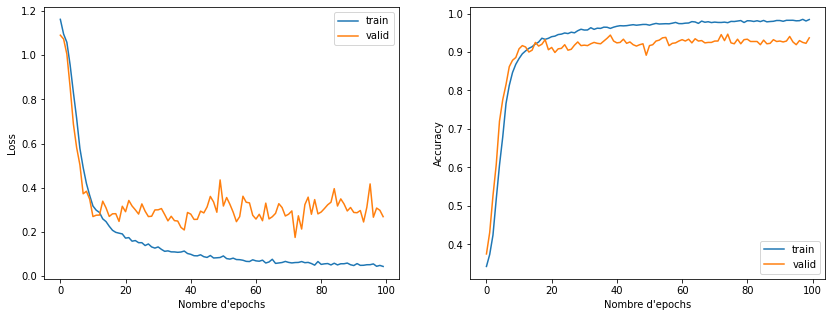

In [ ]:
#add 4 layers with dropout (512,256,128,64) => dataSet 10500 => batch_size 32 => V8
see_curves(trained_model)

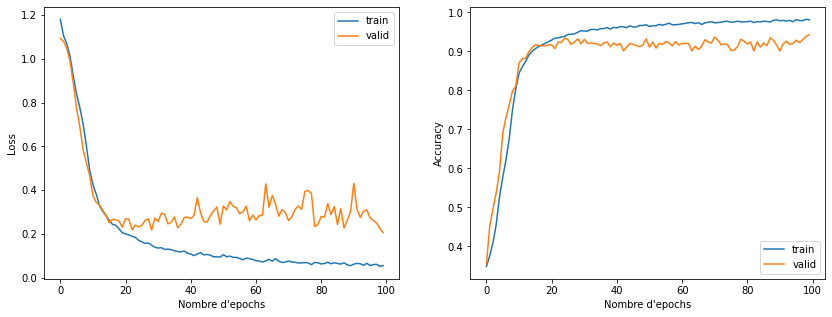

In [ ]:
#add 4 layers with dropout (512,256,128,64) => dataSet 10500 => batch_size 64 => V7
see_curves(trained_model)

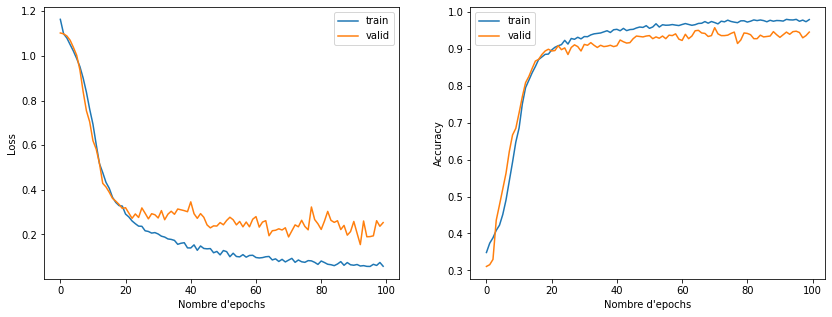

In [ ]:
#add 4 layers with dropout (512,256,128,64) => dataSet 5963 => batch_size 32 => V6
see_curves(trained_model)

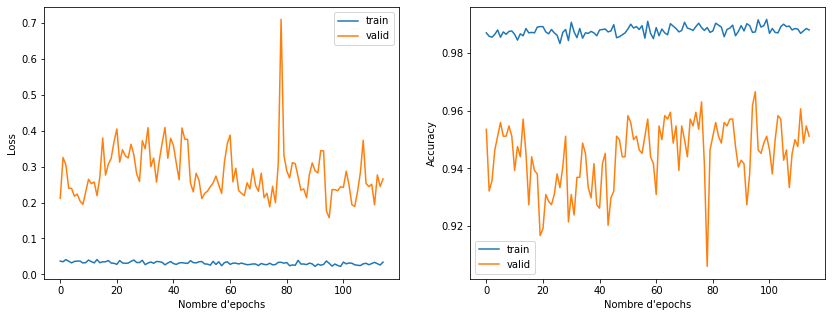

In [ ]:
#add 4 layers with dropout, validation data with datagen bigger dataSet => V5 (save best val_loss) => resumption after 110
see_curves(trained_model)

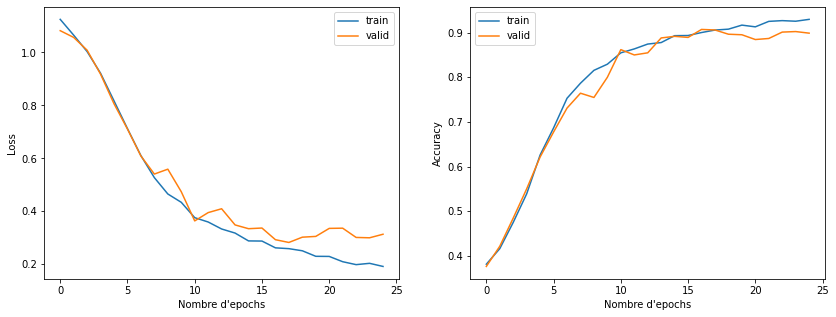

In [ ]:
#add 3 layers with dropout, validation data with datagen bigger dataSet => V3 (save best val_loss)
see_curves(trained_model)

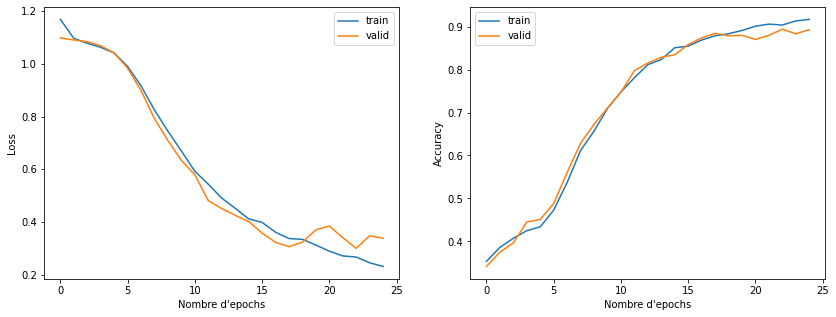

In [ ]:
#add 4 layers with dropout, validation data with datagen bigger dataSet => V4 (save best val_loss)
see_curves(trained_model)

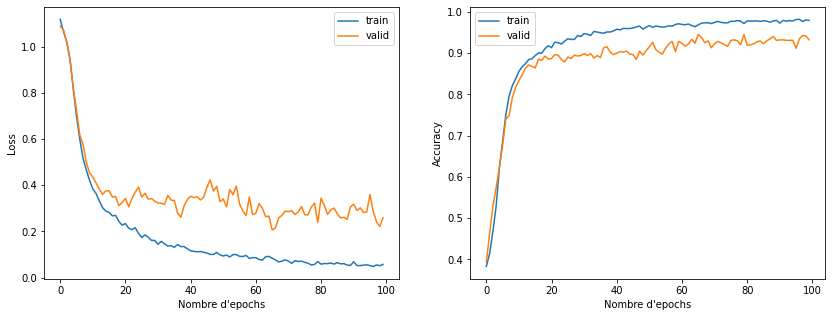

In [ ]:
#add 4 layers with dropout, validation data with datagen (512) bigger dataSet => V2 (save best val_loss)
see_curves(trained_model)

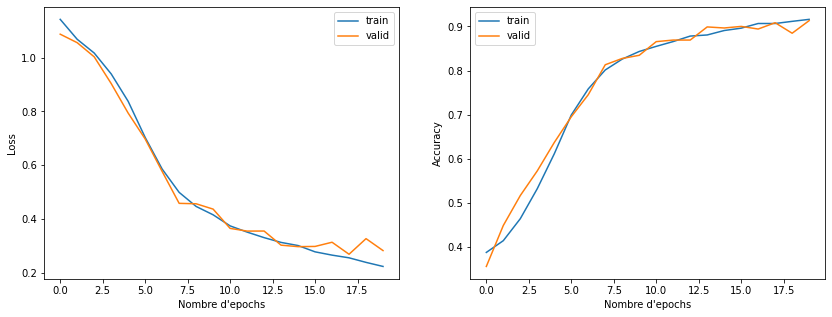

In [ ]:
#add 4 layers with dropout, validation data with datagen (512) bigger dataSet => V1 (save best val_accuracy)
see_curves(trained_model)

# **Small data set**

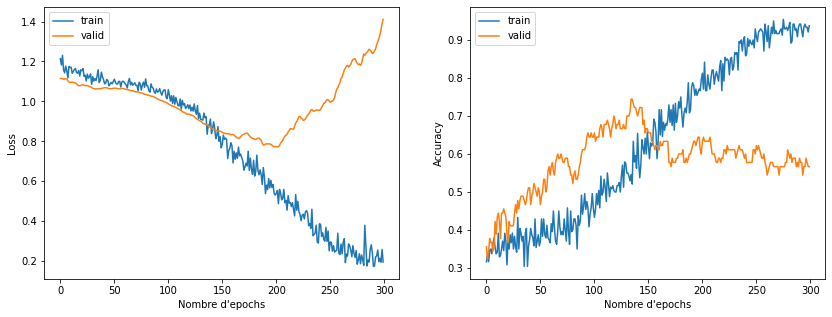

In [ ]:
#add 5 layers with dropout, validation data with rescale (512,64)
see_curves(trained_model)

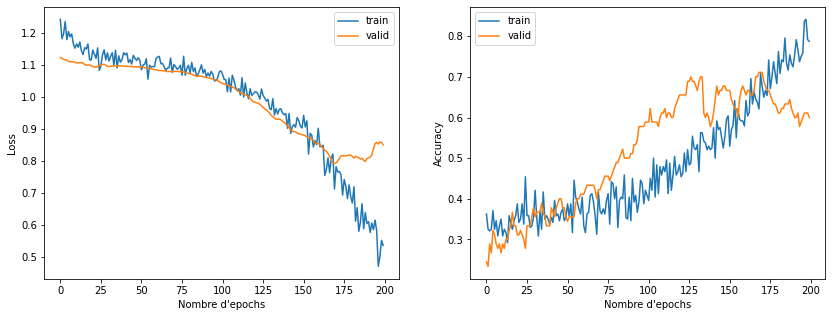

In [ ]:
#add 5 layers with dropout, validation data with rescale (512,64)
see_curves(trained_model)

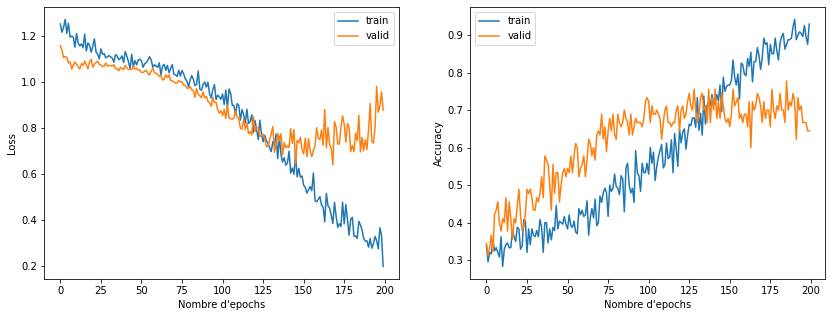

In [ ]:
#add 4 layers with dropout, validation data with datagen (64)
see_curves(trained_model)

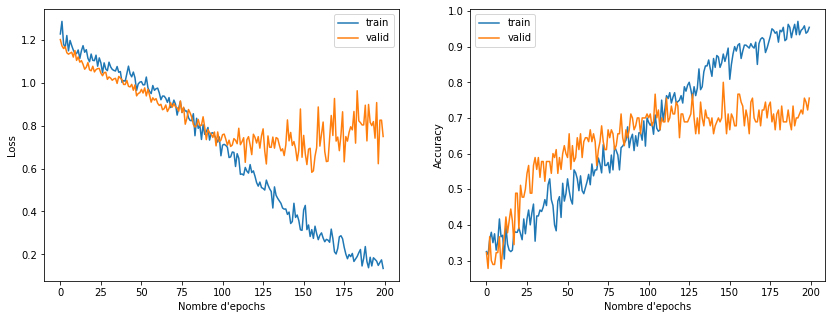

In [ ]:
#add 4 layers with dropout, validation data with datagen (512)
see_curves(trained_model)

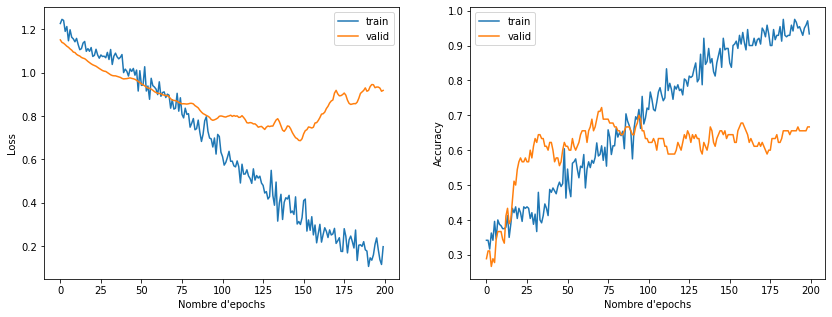

In [ ]:
#add 4 layers with dropout, validation data with rescale (512)
see_curves(trained_model)

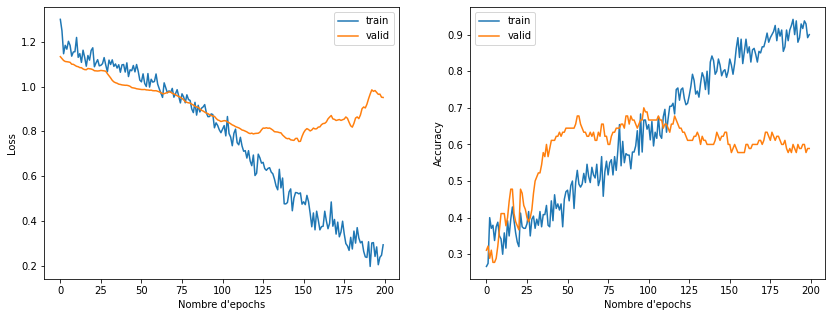

In [ ]:
#add 4 layers with dropout, validation data with rescale (64)
see_curves(trained_model)

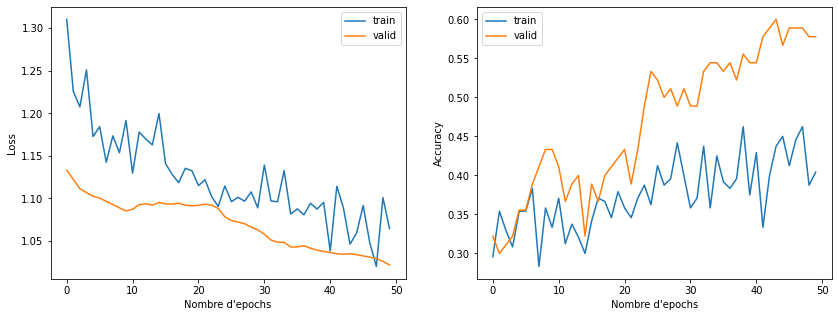

In [ ]:
#add 4 layers with dropout, validation data => with rescale (64)
see_curves(trained_model)

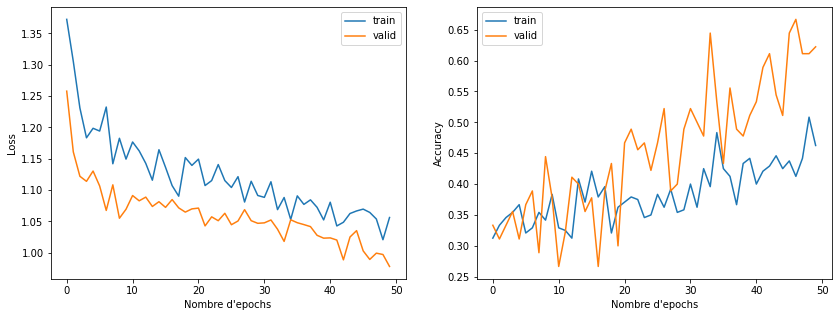

In [ ]:
#add 4 layers with dropout, validation data with datagen (64)
see_curves(trained_model)

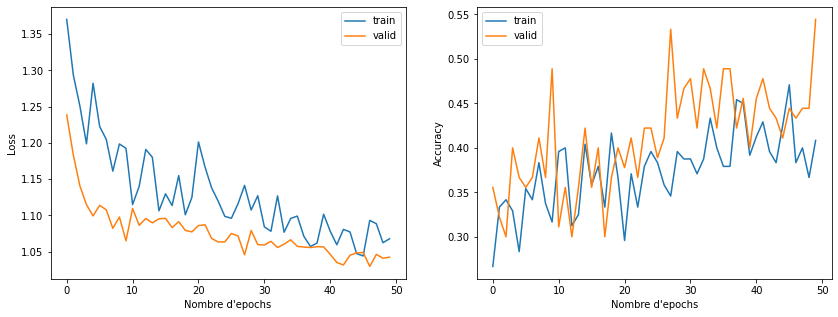

In [ ]:
#add 4 layers with dropout, validation data with datagen (512)
see_curves(trained_model)

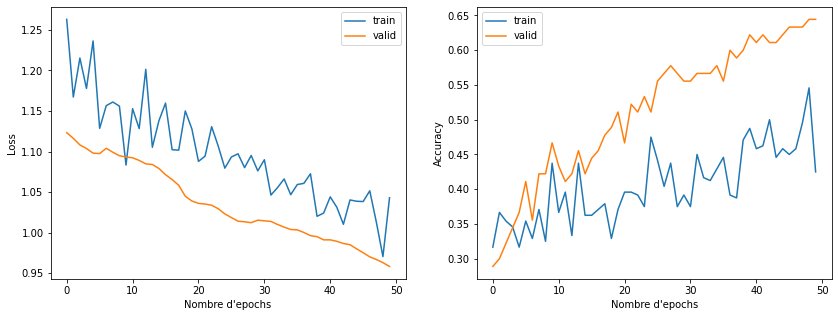

In [ ]:
#add 4 layers with dropout, validation data => with rescale (512)
see_curves(trained_model)

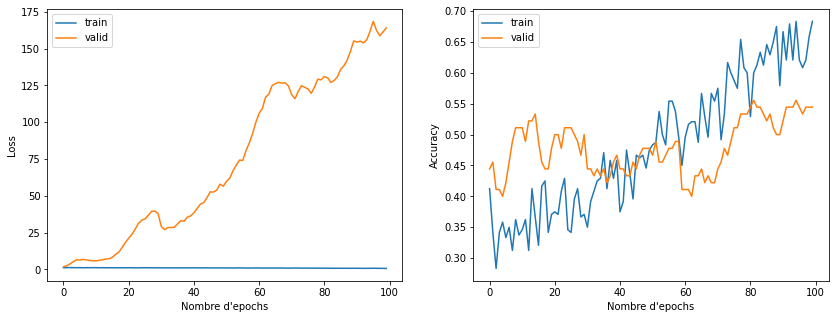

In [ ]:
#add 4 layers with dropout, validation data => without rescale  (512)
see_curves(trained_model)

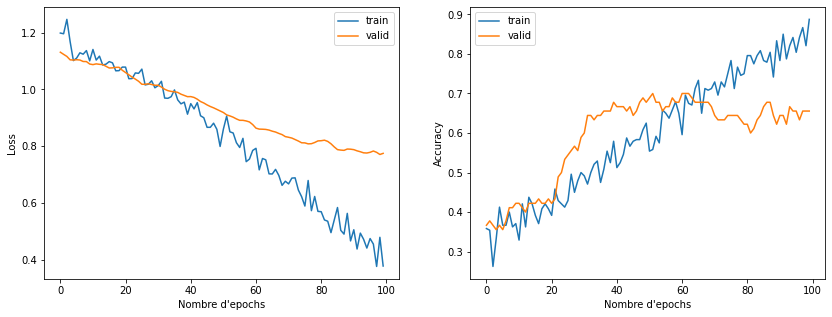

In [ ]:
#add 3 layers with dropout datagen only rescale validation
see_curves(trained_model)

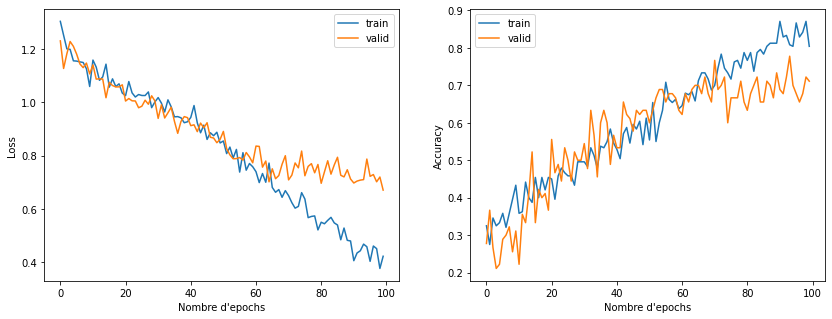

In [ ]:
#add 3 layers with dropout & same datagen
see_curves(trained_model)

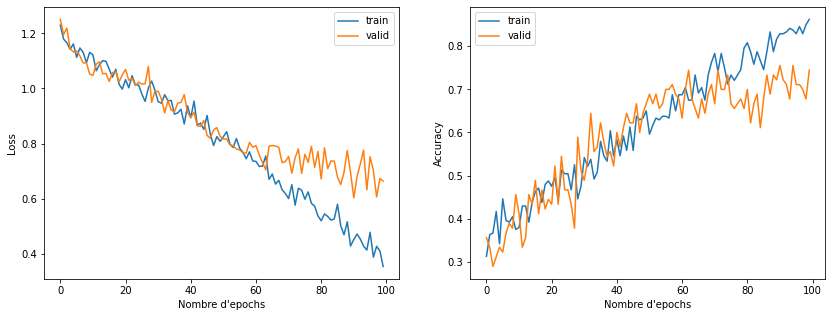

In [ ]:
#add 3 layers with dropout (with input dim)
see_curves(trained_model)

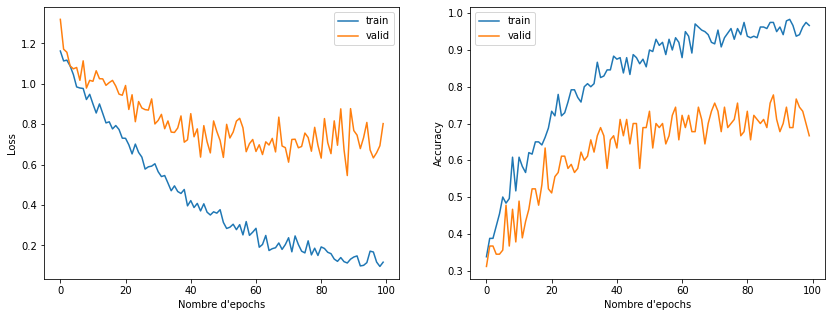

In [ ]:
#add 3 outputs layer without dropout
see_curves(trained_model)